In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math


from scipy.signal import find_peaks
from scipy.integrate import odeint

# Set random seed (for reproducibility)
np.random.seed(1000)

# Start and end time (in milliseconds)
tmin = 0.0
tmax = 1000.0

# Average potassium channel conductance per unit area (mS/cm^2)
gK = 36.0

# Average sodoum channel conductance per unit area (mS/cm^2)
gNa = 120.0

# Average leak channel conductance per unit area (mS/cm^2)
gL = 0.3

# Membrane capacitance per unit area (uF/cm^2)
Cm = 1.0

# Potassium potential (mV)
VK = -12.0

# Sodium potential (mV)
VNa = 115.0

# Leak potential (mV)
Vl = 10.613

# Time values
T = np.linspace(tmin, tmax, 10000)

# Potassium ion-channel rate functions

def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)

def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)

# Sodium ion-channel rate functions

def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)

def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)

def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)

def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)
  
# n, m, and h steady-state values

def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))
  


Table of Variables
n_list
n_k
mean_n_k

In [6]:
# Compute derivatives
def compute_derivatives(y, T):
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    GK = (gK / Cm) * np.power(n, 4.0)
    GNa = (gNa / Cm) * np.power(m, 3.0) * h
    GL = gL / Cm
    
    dy[0] = (id(T) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
    
    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
    
    return dy
  
# State (Vm, n, m, h)
Y = np.array([0.0, n_inf(), m_inf(), h_inf()])


# Solve ODE system
# Vy = (Vm[t0:tmax], n[t0:tmax], m[t0:tmax], h[t0:tmax])


In [7]:
def Vy1(listv):
    Vm_list = []
    for i in Vy:
        Vm_list.append(i[0])

    return Vm_list

In [8]:
I_input = np.linspace(5,200,196)

ISI_list = []
peaklist = []
n_list = []

bin_ranges = [int(np.ceil((i)*10000/32)) for i in range(0,32)]
bin_ranges.append(10000)

print(bin_ranges)
print(f'length of bin_ranges : {len(bin_ranges)}')

pdt_list = [0] * 32


[0, 313, 625, 938, 1250, 1563, 1875, 2188, 2500, 2813, 3125, 3438, 3750, 4063, 4375, 4688, 5000, 5313, 5625, 5938, 6250, 6563, 6875, 7188, 7500, 7813, 8125, 8438, 8750, 9063, 9375, 9688, 10000]
length of bin_ranges : 33


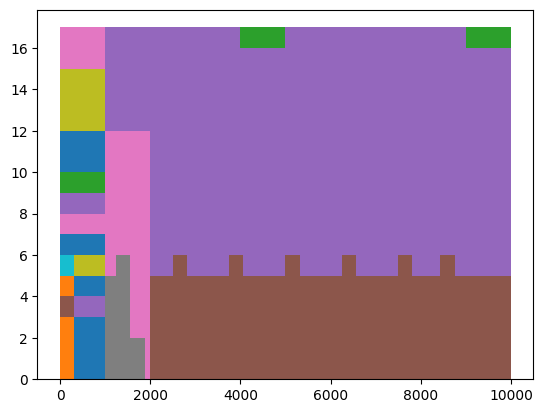

In [9]:

for i in range(0,len(I_input)):
    def id(t):
        return I_input[i]
    Vy = odeint(compute_derivatives, Y, T)


    #Find_peaks gives x-position of peak
    listV = Vy1(Vy)
    peak_data = find_peaks(listV, prominence = 5)[0]
    peaklist.append(len(peak_data))

    
    #This is for later in determining the Fano Factor.
    #Explained in detail in '2.1.1'
    rng1 = np.random.randint(0,10)
    count, bin_edges, patches = plt.hist(peak_data, bins = 10, range = (0,10000))
    n_list.append(count[rng1])


    #This is for later in determining the Peri-Stimulus-Time Histogram
    #Explained in detail in '2.2.1'
    count, bin_edges, patches = plt.hist(peak_data, bins = 32, range = (0,10000))
    pdt_list = np.add(pdt_list, count)



    #For taking ISI intervals
    for k in range(1,len(peak_data)):
        ISI_list.append((peak_data[k] - peak_data[k-1])/10)

In [10]:
#checking if the probability mass function is poisson-like
#pmf_fit here poisson
from scipy.stats import poisson
lambda_hat = np.mean(peaklist)

pmf_fit = poisson.pmf(peaklist, lambda_hat)

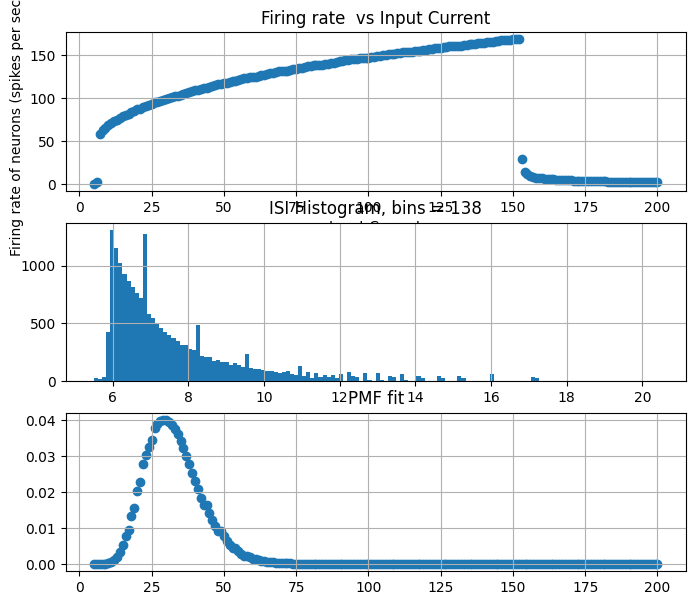

In [11]:
# Neuron potential
fig, axs = plt.subplots(3,1,figsize=(8, 7))
axs[0].scatter(I_input, peaklist)
axs[0].set_xlabel('Input Current')
axs[0].set_ylabel('Firing rate of neurons (spikes per second)')
axs[0].set_title('Firing rate  vs Input Current')
axs[0].grid(True)

bin_num = math.floor(np.sqrt(len(ISI_list)))
axs[1].hist(ISI_list, bins= bin_num )
axs[1].grid(True)
axs[1].set_title(f'ISI Histogram, bins = {bin_num}')
axs[1].grid(True)

axs[2].scatter(I_input, pmf_fit)
axs[2].set_title('PMF fit')
axs[2].grid(True)

In [12]:
#2.1.1 Mean Firing Rate

mean_n = np.mean(n_list)
print(mean_n)

#Deviations
dev_n = [i-mean_n for i in n_list ]
print(dev_n)

#Variance
var_n = np.sum([i**2 for i in dev_n])*(1/len(dev_n))
print(var_n)

#Fano-Factor
F = var_n/mean_n
print(F) 

9.887755102040817
[-9.887755102040817, -9.887755102040817, -3.887755102040817, -2.887755102040817, -3.887755102040817, -2.887755102040817, -2.887755102040817, -2.887755102040817, -2.887755102040817, -1.887755102040817, -1.887755102040817, -0.887755102040817, -1.887755102040817, -1.887755102040817, -1.887755102040817, -1.887755102040817, -0.887755102040817, -0.887755102040817, -0.887755102040817, -0.887755102040817, -0.887755102040817, -0.887755102040817, 0.11224489795918302, 0.11224489795918302, 0.11224489795918302, 0.11224489795918302, 0.11224489795918302, 0.11224489795918302, 0.11224489795918302, 1.112244897959183, 0.11224489795918302, 0.11224489795918302, 1.112244897959183, 0.11224489795918302, 1.112244897959183, 1.112244897959183, 1.112244897959183, 2.112244897959183, 1.112244897959183, 2.112244897959183, 2.112244897959183, 2.112244897959183, 1.112244897959183, 2.112244897959183, 1.112244897959183, 1.112244897959183, 2.112244897959183, 2.112244897959183, 2.112244897959183, 2.112244

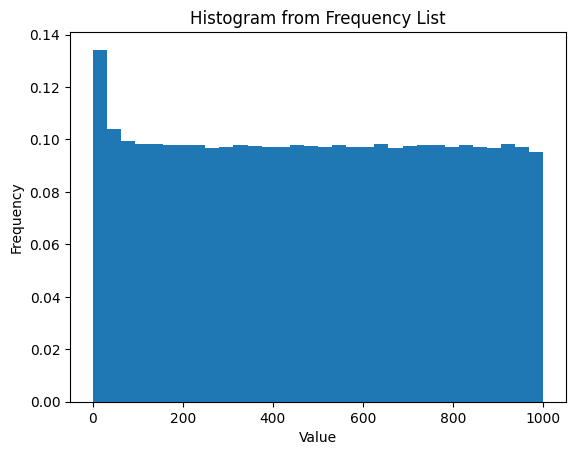

In [13]:
#2.2.1 Peri-Stimulus Time Histogram
# 32 is the bin size
# b*1000/32 and (b+1)*1000/32 defines the ranges of each bin
#bins variable is a list-form of the histogram, += operator allows it to sum each n_k over all runs
def p(dt):
    return (32/1000)*(1/196)*dt


for i in range(len(pdt_list)):
    pdt_list[i] = p(pdt_list[i])



# Number of bins
num_bins = len(pdt_list)

# Create bin edges: assuming you want the bins to be evenly spaced from 0 to 100
bin_edges = np.linspace(0, 1000, num_bins + 1)

# Calculate the center of each bin for plotting
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Create the bar plot
plt.bar(bin_centers, pdt_list, width=(bin_edges[1] - bin_edges[0]))

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram from Frequency List')

# Display the plot
plt.show()


